In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from models.mset import MSET
import warnings 
warnings.filterwarnings('ignore')

from utils.data import create_sequences
from sklearn.preprocessing import StandardScaler
from utils.metrics import mar, far, f1_score

from utils.data import load_df, load_df_with_names, load_df_by_names
from utils.metrics import f1_score, far, mar

from typing import Dict



In [2]:
seed_value = 42

import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

In [3]:
features = ['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure',
       'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS']
# redundant_features = ['anomaly','changepoint','Accelerometer1RMS', 'Accelerometer2RMS', 'Current','Voltage','Pressure','Temperature', 'Thermocouple' ]
redundant_features = ['anomaly','changepoint','Accelerometer1RMS', 'Accelerometer2RMS', 'Current','Voltage','Thermocouple' ]

In [4]:
df_train = pd.read_csv("./data/valve1/6.csv", sep=";", parse_dates=True, index_col="datetime")
df_train.sort_index(inplace=True)

first_anomaly_idx = df_train.index.get_loc(df_train[df_train["anomaly"] == 1].index[0])
df_train = df_train.drop(redundant_features, axis=1)
train_size = int(first_anomaly_idx * 0.9)
train_size

518

In [5]:
x_train = df_train[:train_size]
x_train.head(3)

,Pressure,Temperature,Volume Flow RateRMS
datetime,,,
2020-03-09 12:14:36,0.382638,71.2129,32.0000
2020-03-09 12:14:37,0.710565,71.4284,32.0104
2020-03-09 12:14:38,0.054711,71.3468,32.0000


In [6]:
def movmean(array, window):

    n = np.size(array)
    xx = array.copy()
    y = []
    for i in range(0, window):
        y.append(np.roll(xx.tolist() + [np.nan]*window, i))
    y = np.nanmean(y, axis=0)
    l = math.ceil(window/2)

    return y[l-1:n+l-1]

In [7]:
from utils.pipeline import Pipeline, Predictor
from models.mset import MSET

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

import warnings 
warnings.filterwarnings('ignore')

In [8]:
from utils.pipeline import Pipeline, Predictor
from tensorflow import keras

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
class Config:
    train_size = 400
    window_size = 40
    Q = 0.6 # We know that 35% it is anomalies
    
conf = Config


class MsetPredictor:
    def fit(self, df_train):
        self.model = MSET()
        self.model.fit(df_train)
        
    def predict(self, dfs_test: Dict[str, pd.DataFrame]) -> Dict[str, pd.Series]:
        predictions = {}
        for file_name, df in dfs_test.items():
            y_test = df.anomaly
            df = df.drop(redundant_features, axis=1)
            
            y_pred = self.model.predict(df)

            err = np.linalg.norm((y_pred.T - df), axis=1)
            rel_err = movmean(err/np.linalg.norm(y_pred.T, axis=1), window=Config.window_size)
            UCL = pd.Series(rel_err).quantile(Config.Q)

            prediction = pd.DataFrame((rel_err > UCL), df.index).fillna(0).any(axis=1).astype(int)
            predictions[file_name] = prediction
            plt.plot(y_test)    
            plt.plot(prediction)
            plt.legend(["y_test", "predicted"])
            plt.show()
            
        return predictions
    

In [9]:
%%time
predictor = MsetPredictor()
predictor.fit(df_train)


CPU times: total: 31.2 ms
Wall time: 19 ms


In [10]:
# df_by_names = {"valve2/0.csv": pd.read_csv("data/valve2/0.csv", 
#                           sep=';', 
#                           index_col='datetime', 
#                           parse_dates=True)[:5]}
# df_by_names

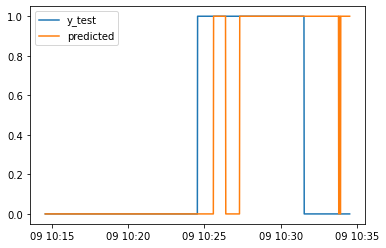

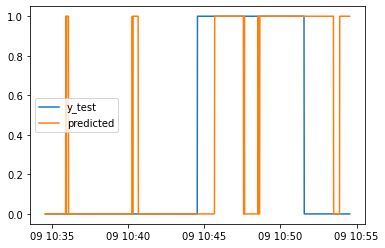

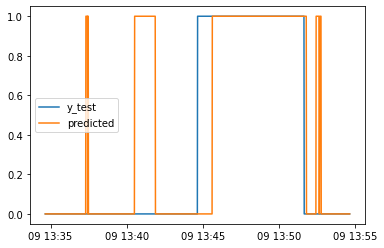

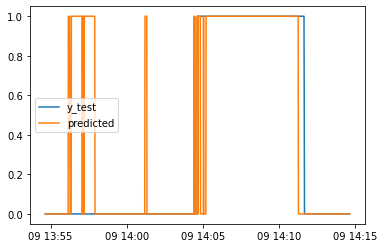

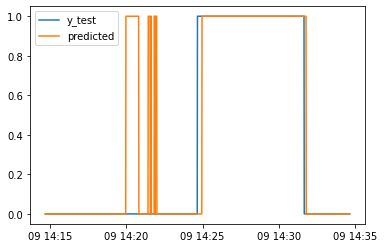

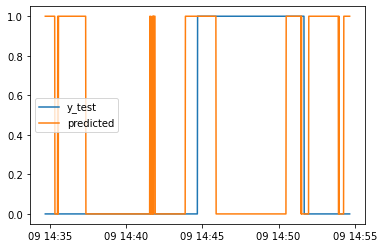

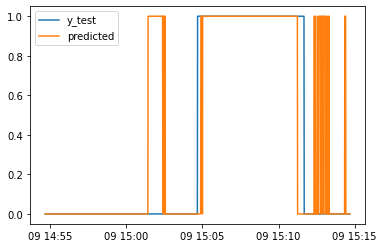

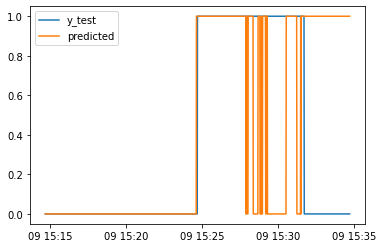

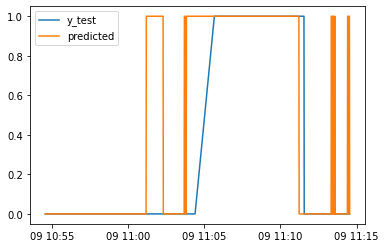

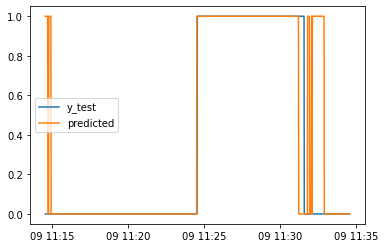

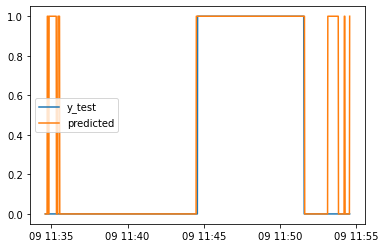

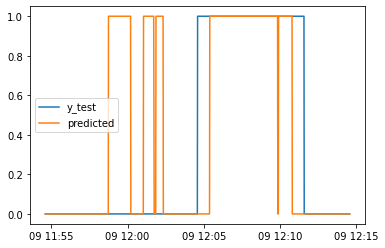

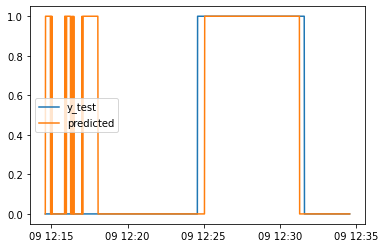

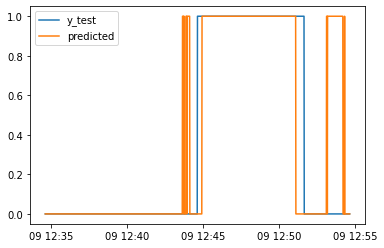

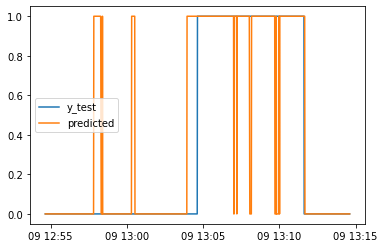

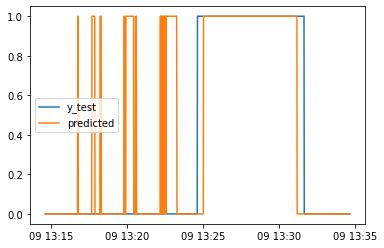

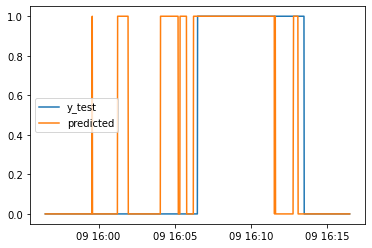

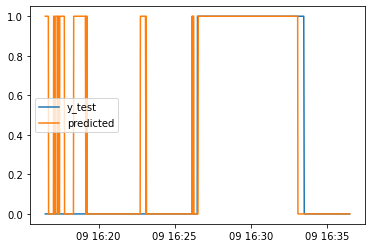

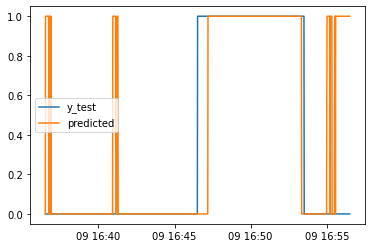

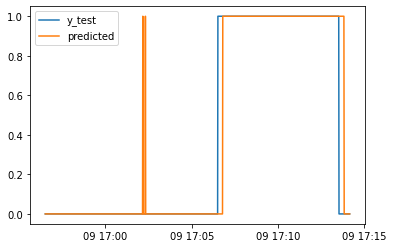

CPU times: total: 23min 9s
Wall time: 25min 30s


In [11]:
%%time

df_by_names = load_df_by_names("./data/", ["valve1", "valve2"])
# df_by_names = load_df_by_names("./data/", ["valve2"])



y_test_by_names = {name: df.anomaly for name, df in df_by_names.items()}
predictions_by_names = predictor.predict(df_by_names)

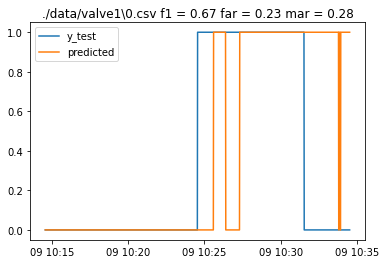

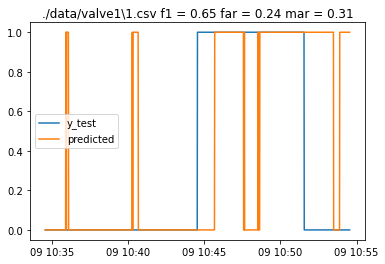

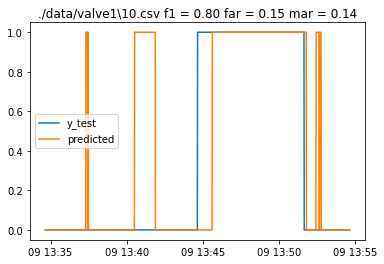

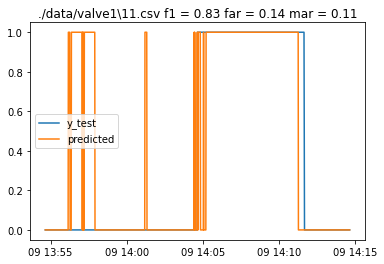

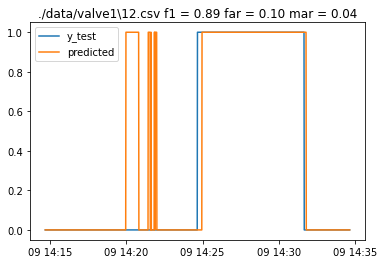

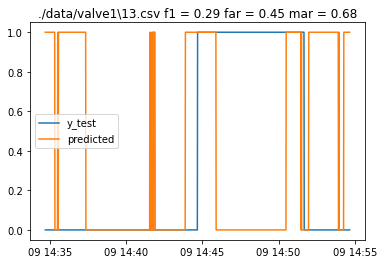

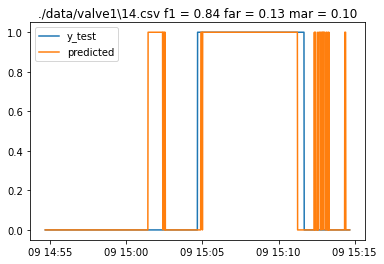

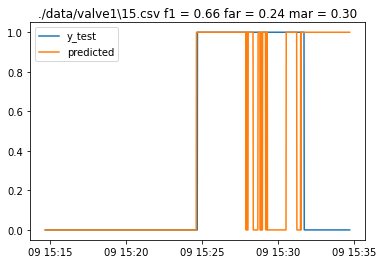

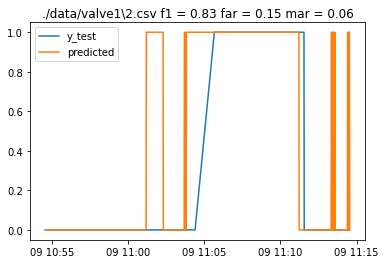

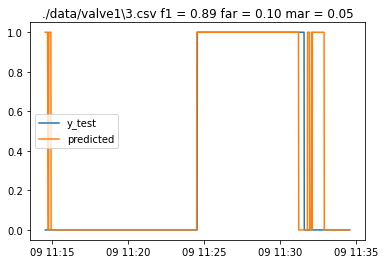

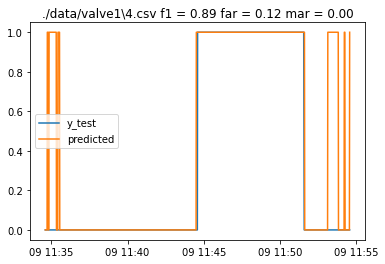

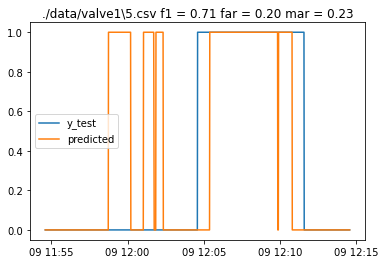

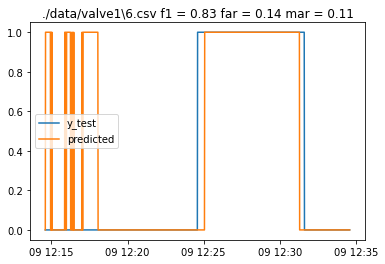

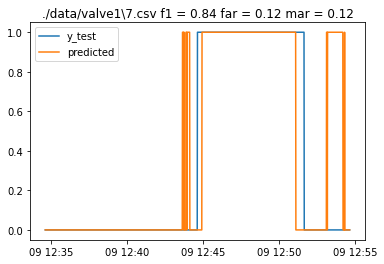

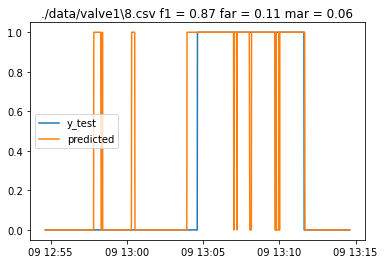

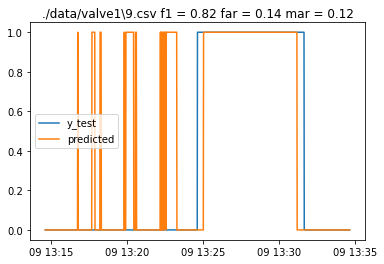

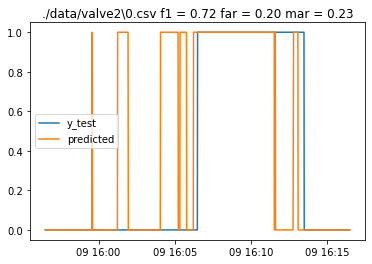

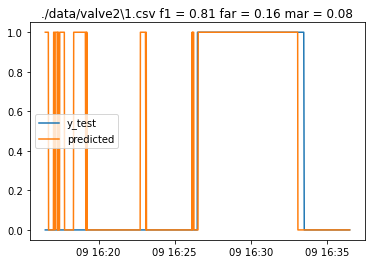

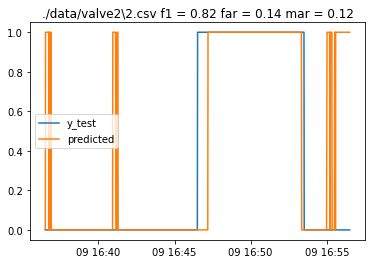

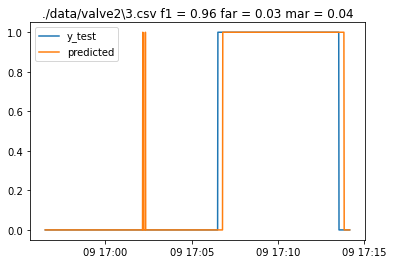

CPU times: total: 5.16 s
Wall time: 6.51 s


In [12]:
%%time
metrics= {}
predictions = []

draw = 1

all_prediction = {"valve1":[], "valve2":[]}
all_test = {"valve1":[], "valve2":[]}

for file_name, prediction in predictions_by_names.items():
    y_test = y_test_by_names[file_name]
    # all_test.append(y_test)
    # all_prediction.append(prediction)
    f1 = f1_score(y_test, prediction)
    far_score = far(y_test, prediction)
    mar_score = mar(y_test, prediction)
    for i in [1,2]:
        if f"valve{i}" in file_name:
            all_prediction[f"valve{i}"].append(prediction)
            all_test[f"valve{i}"].append(y_test)
            
    metrics[file_name[7:]] = (f1, far_score, mar_score)
    
    if draw:
        title = file_name + " f1 = {:3.2f} far = {:3.2f} mar = {:3.2f}".format(f1, far_score, mar_score)
        plt.title(title)
        plt.plot(y_test)    
        plt.plot(prediction)
        plt.legend(["y_test", "predicted"])
        plt.show()

        
grouped_metrics = {}
for group in (g for g in all_prediction if all_prediction[g]):    
    prc = pd.concat(all_prediction[group])
    tc = pd.concat(all_test[group])
    total_f1 = f1_score(tc, prc)
    total_far = far(tc, prc)
    total_mar = mar(tc, prc)
    grouped_metrics[group] = (total_f1, total_far, total_mar)

In [13]:
from utils.data import show_score_table

show_score_table(metrics)

show_score_table(grouped_metrics)

metric | valve1\0.csv | valve1\1.csv | valve1\10.csv | valve1\11.csv | valve1\12.csv | valve1\13.csv | valve1\14.csv | valve1\15.csv | valve1\2.csv | valve1\3.csv | valve1\4.csv | valve1\5.csv | valve1\6.csv | valve1\7.csv | valve1\8.csv | valve1\9.csv | valve2\0.csv | valve2\1.csv | valve2\2.csv | valve2\3.csv
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | ---
F1 |0.67 | 0.65 | 0.8 | 0.83 | 0.89 | 0.29 | 0.84 | 0.66 | 0.83 | 0.89 | 0.89 | 0.71 | 0.83 | 0.84 | 0.87 | 0.82 | 0.72 | 0.81 | 0.82 | 0.96
FAR |0.23 | 0.24 | 0.15 | 0.14 | 0.1 | 0.45 | 0.13 | 0.24 | 0.15 | 0.1 | 0.12 | 0.2 | 0.14 | 0.12 | 0.11 | 0.14 | 0.2 | 0.16 | 0.14 | 0.03
MAR |0.28 | 0.31 | 0.14 | 0.11 | 0.04 | 0.68 | 0.1 | 0.3 | 0.06 | 0.05 | 0.0 | 0.23 | 0.11 | 0.12 | 0.06 | 0.12 | 0.23 | 0.08 | 0.12 | 0.04

metric | valve1 | valve2
--- | --- | ---
F1 |0.77 | 0.83
FAR |0.17 | 0.14
MAR |0.17 | 0.12

### SKAB MSET

In [14]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy import linalg as spla
import os, sys
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

def kernel(x,y):

    '''
    s(x,y) = 1 - ||x-y||/(||x|| + ||y||)
    '''

    if all(x==y):
        # Handling the case of x and y both being the zero vector.
        return 1.
    else:
        return 1. - np.linalg.norm(x-y)/(np.linalg.norm(x) + np.linalg.norm(y))

def otimes(X, Y):

    m1,n = np.shape(X)
    m2,p = np.shape(Y)

    if m1!=m2:
        raise Exception('dimensionality mismatch between X and Y.')

    Z = np.zeros( (n,p) )

    if n != p:
        for i in range(n):
            for j in range(p):
                Z[i,j] = kernel(X[:,i], Y[:,j])
    else:
        for i in range(n):     
            for j in range(i, p):
                Z[i,j] = kernel(X[:,i], Y[:,j])
                Z[j,i] = Z[i,j]

    return Z

In [15]:
class SkabPredictor:        
    def __init__(self):
        pass
    
    def calc_W(self, X_obs):
        
        DxX_obs = otimes(self.D, X_obs)
        try:
            W = spla.lu_solve(self.LU_factors, DxX_obs)
        except:
            W = np.linalg.solve(self.DxD, DxX_obs)
    
        return W

    def fit(self, df):
        
        self.D = df.values.T.copy() # memory matrix
        self.SS = StandardScaler()
        self.D = self.SS.fit_transform(self.D.T).T
        
        self.DxD = otimes(self.D, self.D)
        self.LU_factors = spla.lu_factor(self.DxD)
        
    def predict(self, dfs_test: Dict[str, pd.DataFrame]) -> Dict[str, pd.Series]:
        predictions = {}
        for file_name, df in dfs_test.items():
            y_test = df.anomaly
            df = df.drop(redundant_features, axis=1)
            
            y_pred = self._predict_time_series(df)# 5 3
            
            print("Y-pred")
            print(y_pred)

            err = np.linalg.norm((y_pred - df), axis=1)
            
            print("err")
            print(err)
            # if err.shape[1] > 3: raise ValueError()
            # raise ValueError(y_pred.shape)
            # raise ValueError(err.shape)
            rel_err = movmean(err/np.linalg.norm(y_pred, axis=1), window=Config.window_size)
            UCL = pd.Series(rel_err).quantile(Config.Q)

            prediction = pd.DataFrame((rel_err > UCL), df.index).fillna(0).any(axis=1).astype(int)
            predictions[file_name] = prediction
            plt.plot(y_test)    
            plt.plot(prediction)
            plt.legend(["y_test", "predicted"])
            plt.show()
            
        return predictions
        
    def _predict_time_series(self, df):
        if df.shape[1] > 3: raise ValueError()
        X_obs = df.values.T.copy() 
        X_obs = self.SS.transform(X_obs.T).T
#         pred = pd.DataFrame(index=df.index, columns=df.columns)
        pred = np.zeros(X_obs.T.shape)
        
        for i in range(X_obs.shape[1]):
            pred[[i],:] = (self.D @ self.calc_W(X_obs[:,i].reshape([-1,1]))).T
            
        return pd.DataFrame(self.SS.inverse_transform(pred), index=df.index, columns=df.columns)

In [16]:
%%time
skab_predictor = SkabPredictor()
skab_predictor.fit(df_train)

CPU times: total: 33.6 s
Wall time: 45.7 s


Y-pred
                     Pressure  Temperature  Volume Flow RateRMS
datetime                                                       
2020-03-09 10:14:33  0.207905    71.432035            32.133389
2020-03-09 10:14:34  0.290014    71.471605            32.155798
2020-03-09 10:14:35  0.373035    71.481193            32.180855
2020-03-09 10:14:36  0.285031    71.445735            32.152813
2020-03-09 10:14:37  0.127858    71.381871            32.104104
...                       ...          ...                  ...
2020-03-09 10:34:28  0.188205    71.921659            32.130517
2020-03-09 10:34:29  0.031378    71.863031            32.095871
2020-03-09 10:34:30  0.172440    71.913409            32.133261
2020-03-09 10:34:31  0.200656    71.901860            32.432890
2020-03-09 10:34:32  0.498662    71.891863            32.222875

[1147 rows x 3 columns]
err
[7.90717438 8.04623683 7.90368878 ... 3.72134131 3.90222266 3.834701  ]


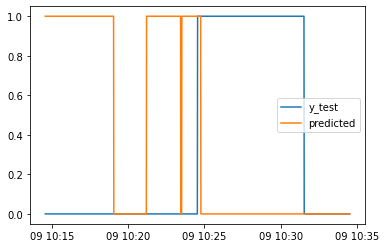

Y-pred
                     Pressure  Temperature  Volume Flow RateRMS
datetime                                                       
2020-03-09 10:34:33  0.171771    71.911835            32.127944
2020-03-09 10:34:34  0.181139    71.933964            32.128458
2020-03-09 10:34:35  0.364139    71.935072            32.476711
2020-03-09 10:34:36  0.197881    71.927011            32.446268
2020-03-09 10:34:37  0.165993    71.939329            32.129144
...                       ...          ...                  ...
2020-03-09 10:54:29  0.075736    71.958120            31.357003
2020-03-09 10:54:30  0.077956    72.164871            32.062170
2020-03-09 10:54:31  0.074772    72.157510            32.056938
2020-03-09 10:54:32  0.356794    71.888724            31.427322
2020-03-09 10:54:33  0.079812    72.172069            32.060154

[1145 rows x 3 columns]
err
[3.58785829 3.61503233 3.76204928 ... 0.55041601 0.98499211 0.56898428]


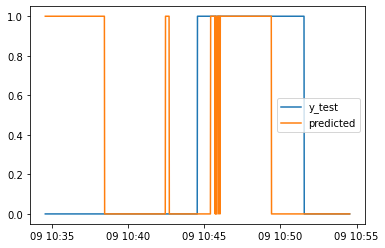

Y-pred
                     Pressure  Temperature  Volume Flow RateRMS
datetime                                                       
2020-03-09 13:34:39 -0.273764    67.965073            32.018177
2020-03-09 13:34:40  0.046293    67.984852            32.040645
2020-03-09 13:34:41  0.047535    68.028429            32.019619
2020-03-09 13:34:43 -0.274877    68.022258            32.032884
2020-03-09 13:34:44  0.052062    68.053212            32.893011
...                       ...          ...                  ...
2020-03-09 13:54:33  0.054810    68.704135            31.998689
2020-03-09 13:54:35  0.054600    68.632146            31.999054
2020-03-09 13:54:36  0.382728    68.785005            31.999995
2020-03-09 13:54:37  0.382795    68.787662            31.999980
2020-03-09 13:54:38  0.055000    68.754947            31.998968

[1146 rows x 3 columns]
err
[0.30661238 0.19425743 0.16287442 ... 0.00079995 0.00105036 0.00120619]


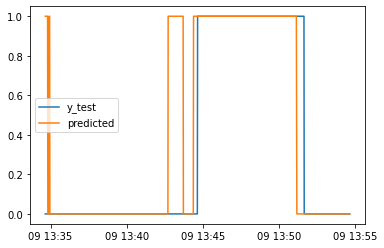

Y-pred
                     Pressure  Temperature  Volume Flow RateRMS
datetime                                                       
2020-03-09 13:54:39  0.054612    68.636860            31.998903
2020-03-09 13:54:40  0.055073    68.798735            31.999021
2020-03-09 13:54:41 -0.273218    68.930903            31.999981
2020-03-09 13:54:42 -0.273211    68.935344            31.999876
2020-03-09 13:54:43  0.056292    68.782544            31.998796
...                       ...          ...                  ...
2020-03-09 14:14:35  0.382597    69.571035            32.982711
2020-03-09 14:14:36  0.054594    69.428125            31.999797
2020-03-09 14:14:37  0.043287    69.523780            32.015947
2020-03-09 14:14:38  0.050956    69.517798            32.982282
2020-03-09 14:14:39 -0.273217    69.517098            32.000000

[1141 rows x 3 columns]
err
[2.23074700e-03 2.04996352e-03 1.90927973e-05 ... 4.98700525e-02
 7.99317493e-03 1.73125372e-06]


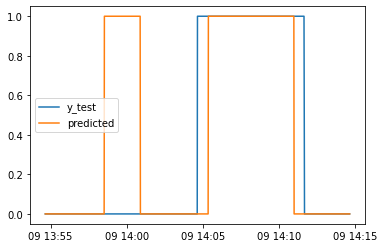

Y-pred
                     Pressure  Temperature  Volume Flow RateRMS
datetime                                                       
2020-03-09 14:14:40  0.058961    69.470203            32.028982
2020-03-09 14:14:41  0.058841    69.484416            32.978852
2020-03-09 14:14:42  0.383608    69.435644            32.022722
2020-03-09 14:14:43 -0.274269    69.587049            32.979602
2020-03-09 14:14:44  0.048980    69.458452            32.031726
...                       ...          ...                  ...
2020-03-09 14:34:36 -0.601012    69.144889            31.999525
2020-03-09 14:34:37 -0.273287    69.061483            31.999683
2020-03-09 14:34:38  0.055196    68.855159            31.998539
2020-03-09 14:34:39 -0.273115    68.945279            31.999718
2020-03-09 14:34:40  0.382594    68.657584            31.998925

[1140 rows x 3 columns]
err
[0.02279761 0.01171395 0.01994242 ... 0.00176267 0.00040895 0.00194134]


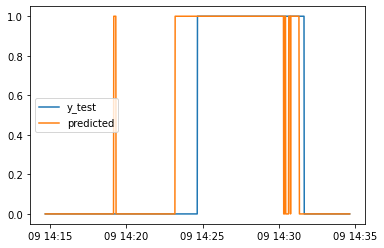

Y-pred
                     Pressure  Temperature  Volume Flow RateRMS
datetime                                                       
2020-03-09 14:34:41 -0.273302    68.669036            32.028180
2020-03-09 14:34:42  0.053956    68.692054            32.976713
2020-03-09 14:34:43 -0.273351    68.617992            32.028458
2020-03-09 14:34:44  0.055423    68.540578            32.978080
2020-03-09 14:34:45 -0.273218    68.585371            31.999982
...                       ...          ...                  ...
2020-03-09 14:54:36 -0.179418    67.987277            32.469593
2020-03-09 14:54:37  0.252009    68.010946            32.024362
2020-03-09 14:54:38 -0.210899    67.895639            32.008315
2020-03-09 14:54:39  0.031158    67.966093            32.508355
2020-03-09 14:54:40  0.019346    67.889276            32.022646

[1140 rows x 3 columns]
err
[1.94160301e-03 3.00451293e-03 2.68550381e-03 ... 1.76426143e+00
 1.98647758e+00 1.83962741e+00]


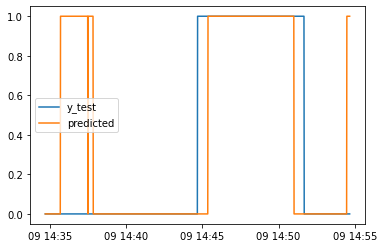

Y-pred
                     Pressure  Temperature  Volume Flow RateRMS
datetime                                                       
2020-03-09 14:54:41  0.031322    67.948372            32.510756
2020-03-09 14:54:42 -0.402933    67.999833            31.969982
2020-03-09 14:54:43  0.019389    67.895475            32.006171
2020-03-09 14:54:44  0.019986    67.872580            32.007157
2020-03-09 14:54:46  0.020043    67.881190            32.023751
...                       ...          ...                  ...
2020-03-09 15:14:36  0.383347    68.376854            32.975636
2020-03-09 15:14:37  0.383008    68.367054            32.032777
2020-03-09 15:14:38  0.054872    68.443619            32.976451
2020-03-09 15:14:39 -0.606601    68.355175            32.035500
2020-03-09 15:14:40  0.054903    68.428031            32.996761

[1139 rows x 3 columns]
err
[1.95780035 1.95543658 1.87921755 ... 0.00707966 0.01822731 0.00331266]


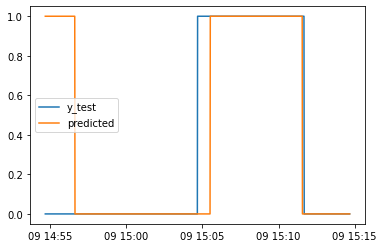

Y-pred
                     Pressure  Temperature  Volume Flow RateRMS
datetime                                                       
2020-03-09 15:14:41  0.383623    68.476365            32.975765
2020-03-09 15:14:42  0.051988    68.224979            32.040216
2020-03-09 15:14:43 -0.273329    68.436026            32.998581
2020-03-09 15:14:45 -0.273317    68.419860            32.032905
2020-03-09 15:14:46  0.054420    68.430430            32.996818
...                       ...          ...                  ...
2020-03-09 15:34:37  0.382581    68.416895            32.973985
2020-03-09 15:34:38  0.051018    68.131124            32.013539
2020-03-09 15:34:39  0.053330    68.209721            32.043646
2020-03-09 15:34:40  0.383212    68.223008            32.973749
2020-03-09 15:34:41 -0.273709    68.234485            32.036172

[1150 rows x 3 columns]
err
[0.00787681 0.02407768 0.00450438 ... 0.02798443 0.00677444 0.00808836]


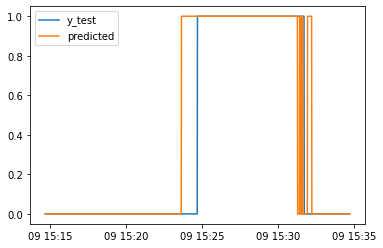

Y-pred
                     Pressure  Temperature  Volume Flow RateRMS
datetime                                                       
2020-03-09 10:54:34  0.349701    71.940330            31.474145
2020-03-09 10:54:35  0.083403    72.175513            32.063970
2020-03-09 10:54:36  0.087466    71.998976            31.370724
2020-03-09 10:54:37  0.387428    72.132629            32.101703
2020-03-09 10:54:38  0.087877    71.976382            31.401939
...                       ...          ...                  ...
2020-03-09 11:14:29  0.055834    71.895322            32.008165
2020-03-09 11:14:30 -0.571682    71.829590            32.004842
2020-03-09 11:14:31  0.056087    71.871436            32.001615
2020-03-09 11:14:32  0.064032    71.841722            31.194411
2020-03-09 11:14:33  0.061230    71.992139            32.019142

[1075 rows x 3 columns]
err
[1.12185936 0.69452763 0.92826146 ... 0.02608778 0.40810612 0.11023144]


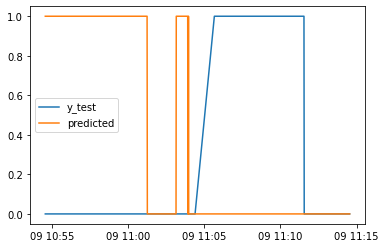

Y-pred
                     Pressure  Temperature  Volume Flow RateRMS
datetime                                                       
2020-03-09 11:14:34  0.057739    71.936382            32.013375
2020-03-09 11:14:35  0.056065    71.867336            32.004960
2020-03-09 11:14:36  0.382939    71.923066            32.030011
2020-03-09 11:14:37 -0.268614    71.912868            32.013203
2020-03-09 11:14:38 -0.272258    71.828419            32.003138
...                       ...          ...                  ...
2020-03-09 11:34:30  0.054739    71.392117            31.999889
2020-03-09 11:34:31  0.382588    71.395141            32.005955
2020-03-09 11:34:32  0.054679    71.425748            32.989362
2020-03-09 11:34:34  0.053084    71.190147            30.963536
2020-03-09 11:34:35  0.054868    71.490060            32.993071

[1148 rows x 3 columns]
err
[0.07066167 0.02539042 0.12528185 ... 0.00026785 0.06734725 0.0014387 ]


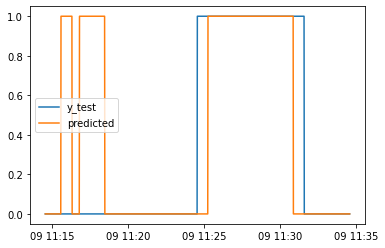

Y-pred
                     Pressure  Temperature  Volume Flow RateRMS
datetime                                                       
2020-03-09 11:34:36 -0.273307    71.187227            31.999941
2020-03-09 11:34:37  0.054710    71.375406            31.999994
2020-03-09 11:34:38  0.054707    71.380905            31.999981
2020-03-09 11:34:39 -0.273462    71.108658            32.000028
2020-03-09 11:34:40 -0.273195    71.306137            31.999730
...                       ...          ...                  ...
2020-03-09 11:54:30  0.054706    70.993409            31.999988
2020-03-09 11:54:32  0.054713    71.106086            31.999991
2020-03-09 11:54:33  0.382930    71.040444            31.998142
2020-03-09 11:54:34  0.054711    70.959301            32.000000
2020-03-09 11:54:35  0.054655    70.932342            32.010502

[1095 rows x 3 columns]
err
[4.40386823e-04 8.56246761e-06 1.97513729e-05 ... 4.01154326e-03
 8.14416638e-07 3.18851399e-03]


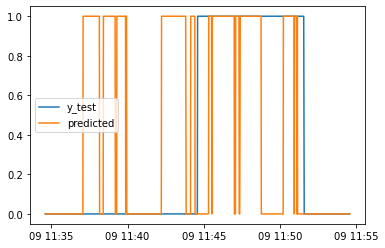

Y-pred
                     Pressure  Temperature  Volume Flow RateRMS
datetime                                                       
2020-03-09 11:54:36  0.054598    70.977119            32.986891
2020-03-09 11:54:37  0.053528    71.078747            30.954296
2020-03-09 11:54:38  0.382882    71.063373            31.998188
2020-03-09 11:54:39 -0.274219    70.993260            32.001412
2020-03-09 11:54:40  0.054717    71.077025            31.999985
...                       ...          ...                  ...
2020-03-09 12:14:31  0.054711    71.226701            31.999999
2020-03-09 12:14:32  0.054713    71.256384            31.999989
2020-03-09 12:14:33  0.054940    71.176713            32.011627
2020-03-09 12:14:34 -0.273387    71.349757            32.990092
2020-03-09 12:14:35  0.054711    71.260103            31.999998

[1154 rows x 3 columns]
err
[2.77394078e-03 6.96446002e-02 2.76383266e-03 ... 1.25380309e-03
 1.08810109e-03 3.43882752e-06]


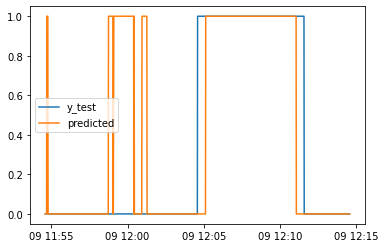

Y-pred
                      Pressure  Temperature  Volume Flow RateRMS
datetime                                                        
2020-03-09 12:14:36   0.382638    71.212900            32.000000
2020-03-09 12:14:37   0.710565    71.428400            32.010400
2020-03-09 12:14:38   0.054711    71.346800            32.000000
2020-03-09 12:14:39  -0.273216    71.325800            32.010400
2020-03-09 12:14:41   0.382638    71.272500            33.000000
...                        ...          ...                  ...
2020-03-09 12:34:31  -0.155547    69.726098            32.946908
2020-03-09 12:34:32   0.668515    58.899265            30.855848
2020-03-09 12:34:33   0.054719    69.944430            32.987500
2020-03-09 12:34:34  -0.296043    69.952698            32.962687
2020-03-09 12:34:35  19.423620   107.752207            25.235783

[1154 rows x 3 columns]
err
[0.00000000e+00 9.76996262e-15 1.43130057e-14 ... 3.10875907e-05
 3.37335502e-02 4.30118030e+01]


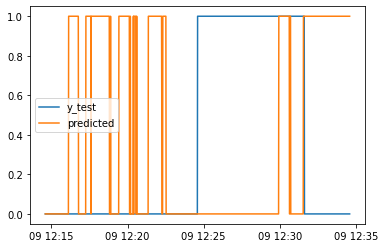

Y-pred
                     Pressure  Temperature  Volume Flow RateRMS
datetime                                                       
2020-03-09 12:34:37  0.170529    70.121867            32.996303
2020-03-09 12:34:38 -0.274208    69.916955            32.012946
2020-03-09 12:34:39  0.054345    69.888048            32.988038
2020-03-09 12:34:40 -0.187671    69.927207            32.035843
2020-03-09 12:34:41 -0.274196    69.912238            32.012474
...                       ...          ...                  ...
2020-03-09 12:54:33  0.058009    70.083448            32.001455
2020-03-09 12:54:34  0.457938    70.336528            31.985075
2020-03-09 12:54:35  0.054700    70.047853            32.000040
2020-03-09 12:54:36  0.383306    70.103730            31.015160
2020-03-09 12:54:37  0.092786    69.948706            32.000940

[1094 rows x 3 columns]
err
[0.23125362 0.00246414 0.00205415 ... 0.00104802 0.00167061 0.21066574]


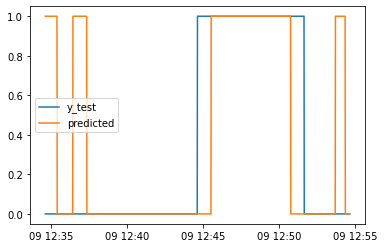

Y-pred
                     Pressure  Temperature  Volume Flow RateRMS
datetime                                                       
2020-03-09 12:54:39  0.310851    69.653554            32.019378
2020-03-09 12:54:40  0.054735    69.880154            32.000854
2020-03-09 12:54:41  0.079274    70.183984            31.997081
2020-03-09 12:54:42  1.608863    66.956518            32.129144
2020-03-09 12:54:43  0.381886    70.119843            31.998582
...                       ...          ...                  ...
2020-03-09 13:14:32  0.054719    69.317609            31.999990
2020-03-09 13:14:34 -0.273219    69.321909            31.999859
2020-03-09 13:14:35  0.054654    69.201927            31.999857
2020-03-09 13:14:36 -0.273403    69.258113            32.017813
2020-03-09 13:14:37 -0.601162    69.284248            32.983087

[1144 rows x 3 columns]
err
[3.66468967e-01 1.49783299e-02 4.45763639e-02 ... 7.87788834e-04
 4.52995179e-04 1.25967376e-04]


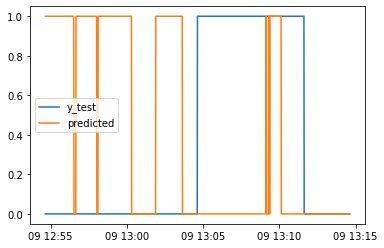

Y-pred
                     Pressure  Temperature  Volume Flow RateRMS
datetime                                                       
2020-03-09 13:14:38  0.382629    69.530794            31.999570
2020-03-09 13:14:39  0.710633    69.341797            31.999705
2020-03-09 13:14:40  0.054689    69.098669            31.999579
2020-03-09 13:14:41  0.054791    69.170407            31.999911
2020-03-09 13:14:42  0.054828    69.286084            31.999809
...                       ...          ...                  ...
2020-03-09 13:34:34  0.041857    67.932240            32.024137
2020-03-09 13:34:35  0.040239    67.882950            32.024351
2020-03-09 13:34:36  0.350420    68.016389            32.025981
2020-03-09 13:34:37 -0.271695    67.956050            32.017277
2020-03-09 13:34:38 -0.268773    67.947658            32.018236

[1148 rows x 3 columns]
err
[1.47000023e-03 3.03023298e-04 1.30090173e-03 ... 3.58784083e-01
 2.90268822e-01 3.44968559e-01]


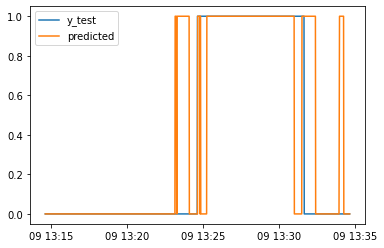

Y-pred
                     Pressure  Temperature  Volume Flow RateRMS
datetime                                                       
2020-03-09 15:56:30  0.054695    68.619412            32.038548
2020-03-09 15:56:31  0.383891    68.584936            32.971863
2020-03-09 15:56:32  0.054063    68.519002            32.038640
2020-03-09 15:56:33  0.383157    68.531831            32.971949
2020-03-09 15:56:34 -0.273188    68.657132            31.999286
...                       ...          ...                  ...
2020-03-09 16:16:25  0.355004    68.031743            32.024116
2020-03-09 16:16:26  0.360961    68.047241            32.057281
2020-03-09 16:16:27  0.047367    67.992692            32.837999
2020-03-09 16:16:28 -0.274041    68.003624            32.015604
2020-03-09 16:16:29  0.046399    67.982793            32.021843

[1125 rows x 3 columns]
err
[0.00234799 0.01021172 0.00304267 ... 0.35303167 0.22596531 0.20036081]


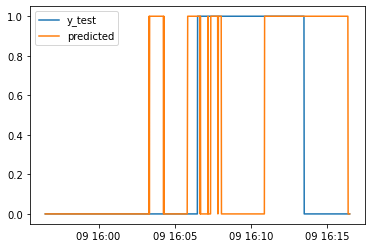

Y-pred
                     Pressure  Temperature  Volume Flow RateRMS
datetime                                                       
2020-03-09 16:16:30  0.047154    68.009300            32.020600
2020-03-09 16:16:31  0.047519    68.023949            32.019549
2020-03-09 16:16:32  0.047554    67.993574            32.021436
2020-03-09 16:16:33 -0.274731    68.012113            32.014747
2020-03-09 16:16:34  0.042517    67.965539            32.021779
...                       ...          ...                  ...
2020-03-09 16:36:26  0.042702    67.924037            32.024684
2020-03-09 16:36:27 -0.273976    68.042463            32.013611
2020-03-09 16:36:28  0.042676    67.940236            31.987348
2020-03-09 16:36:29  0.038583    68.224154            31.122633
2020-03-09 16:36:30  0.045559    67.968779            31.985376

[1063 rows x 3 columns]
err
[0.17617152 0.15495518 0.20661359 ... 0.32429039 0.26783984 0.25716767]


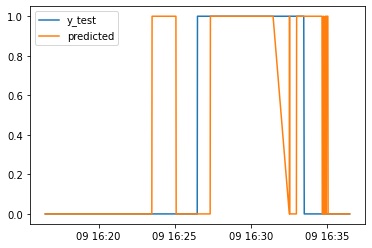

Y-pred
                     Pressure  Temperature  Volume Flow RateRMS
datetime                                                       
2020-03-09 16:36:31  0.336952    68.301290            31.199518
2020-03-09 16:36:32  0.048131    68.009531            32.020519
2020-03-09 16:36:33  0.046329    68.013408            32.020758
2020-03-09 16:36:34  0.365525    68.072781            32.018198
2020-03-09 16:36:36  0.366465    68.079902            32.017341
...                       ...          ...                  ...
2020-03-09 16:56:25  0.385485    69.024446            31.954246
2020-03-09 16:56:26 -0.273551    69.209261            31.042409
2020-03-09 16:56:28  0.054585    69.048039            32.000048
2020-03-09 16:56:29  0.057817    69.011008            31.950259
2020-03-09 16:56:30  0.050556    69.179195            31.032590

[1129 rows x 3 columns]
err
[4.94078931e-01 1.66233712e-01 1.70484470e-01 ... 2.09524251e-04
 9.99149732e-03 2.71674916e-02]


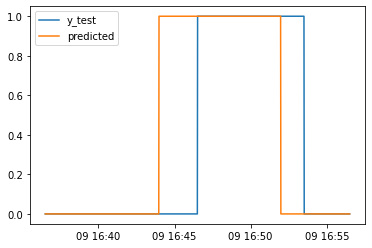

Y-pred
                     Pressure  Temperature  Volume Flow RateRMS
datetime                                                       
2020-03-09 16:56:31  0.054681    69.173935            31.999957
2020-03-09 16:56:32  0.054403    69.004818            31.998582
2020-03-09 16:56:33  0.054934    69.028257            31.999761
2020-03-09 16:56:34 -0.273843    68.991452            32.045887
2020-03-09 16:56:35  0.057092    68.960850            32.968990
...                       ...          ...                  ...
2020-03-09 17:14:04  0.065334    69.717635            32.059168
2020-03-09 17:14:05  0.033227    69.546450            32.974350
2020-03-09 17:14:07  0.056681    69.731004            32.001455
2020-03-09 17:14:08 -0.273055    69.630677            31.999782
2020-03-09 17:14:09 -0.274166    69.723885            32.000340

[995 rows x 3 columns]
err
[1.73139750e-04 2.07456682e-03 9.03592084e-04 3.15836626e-03
 1.12996219e-02 1.44390169e-02 4.23291844e-02 1.39071814e-03
 3.08638495

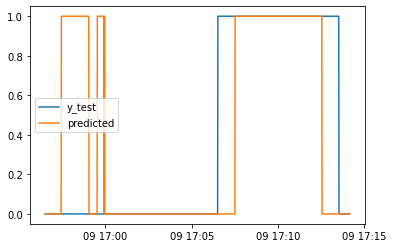

CPU times: total: 19min 35s
Wall time: 21min 7s


In [17]:
%%time
skab_predictions_by_names = skab_predictor.predict(df_by_names)

In [18]:
skab_predictions_by_names

{'./data/valve1\\0.csv': datetime
 2020-03-09 10:14:33    1
 2020-03-09 10:14:34    1
 2020-03-09 10:14:35    1
 2020-03-09 10:14:36    1
 2020-03-09 10:14:37    1
                       ..
 2020-03-09 10:34:28    0
 2020-03-09 10:34:29    0
 2020-03-09 10:34:30    0
 2020-03-09 10:34:31    0
 2020-03-09 10:34:32    0
 Length: 1147, dtype: int32,
 './data/valve1\\1.csv': datetime
 2020-03-09 10:34:33    1
 2020-03-09 10:34:34    1
 2020-03-09 10:34:35    1
 2020-03-09 10:34:36    1
 2020-03-09 10:34:37    1
                       ..
 2020-03-09 10:54:29    0
 2020-03-09 10:54:30    0
 2020-03-09 10:54:31    0
 2020-03-09 10:54:32    0
 2020-03-09 10:54:33    0
 Length: 1145, dtype: int32,
 './data/valve1\\10.csv': datetime
 2020-03-09 13:34:39    1
 2020-03-09 13:34:40    1
 2020-03-09 13:34:41    1
 2020-03-09 13:34:43    1
 2020-03-09 13:34:44    1
                       ..
 2020-03-09 13:54:33    0
 2020-03-09 13:54:35    0
 2020-03-09 13:54:36    0
 2020-03-09 13:54:37    0
 2020-0

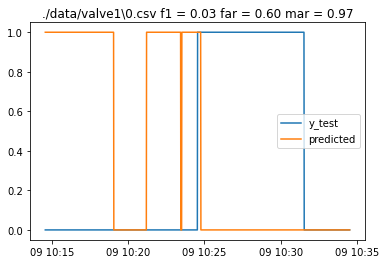

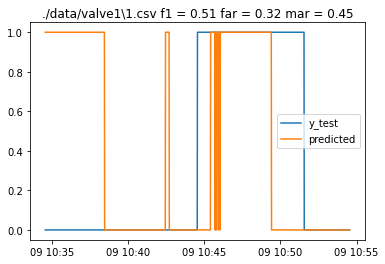

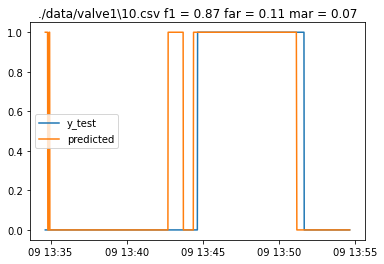

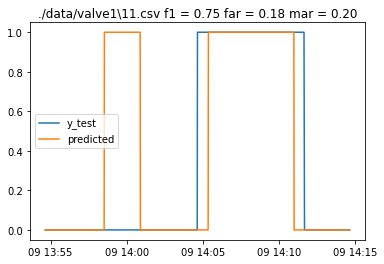

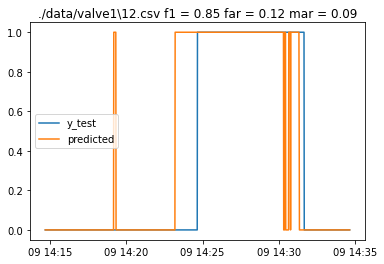

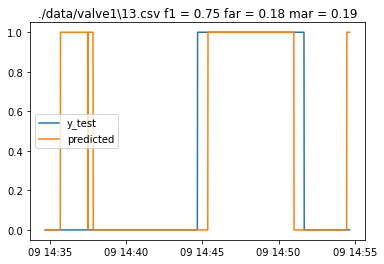

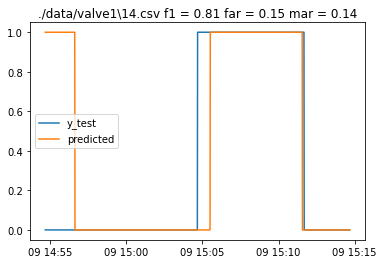

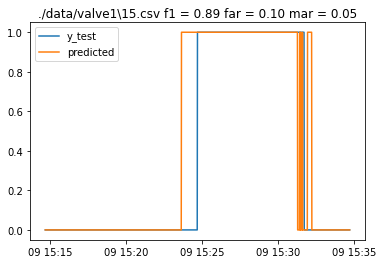

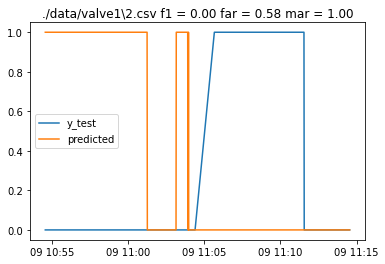

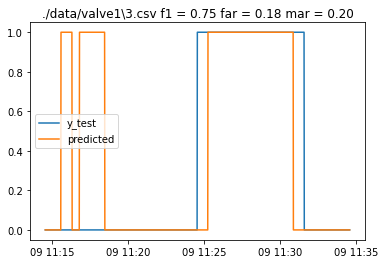

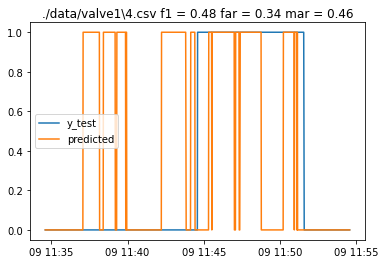

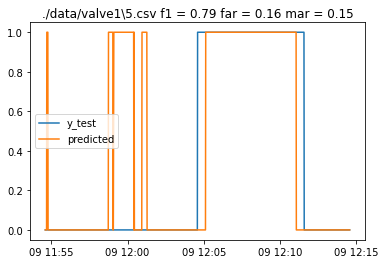

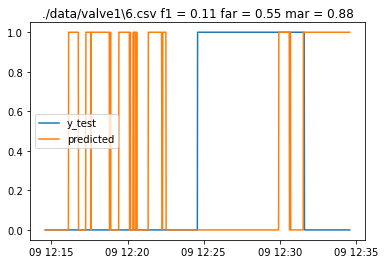

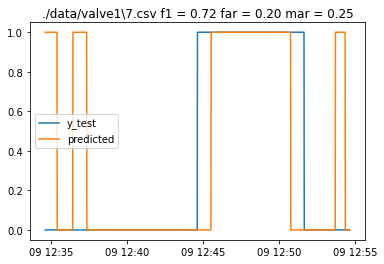

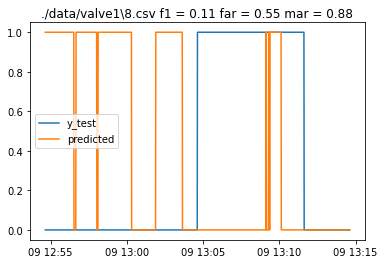

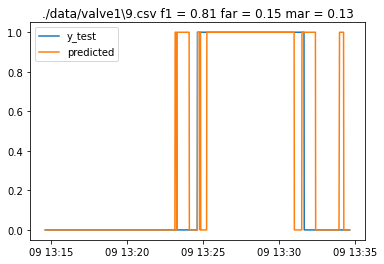

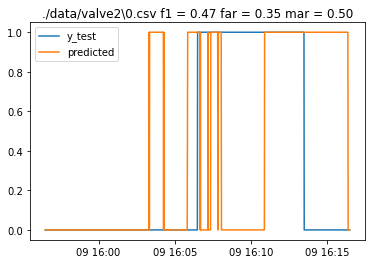

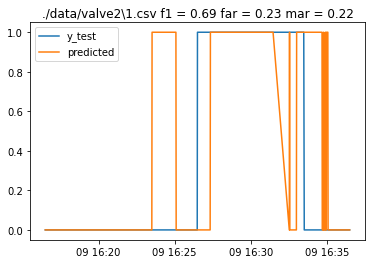

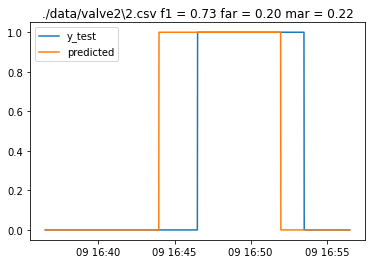

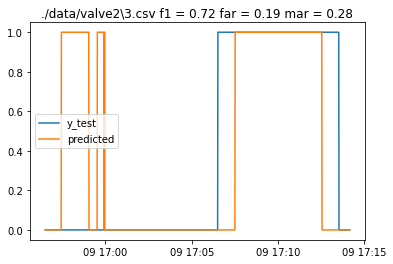

CPU times: total: 4.12 s
Wall time: 4.25 s


In [19]:
%%time
metrics= {}
predictions = []

draw = 1

all_prediction = {"valve1":[], "valve2":[]}
all_test = {"valve1":[], "valve2":[]}

for file_name, prediction in skab_predictions_by_names.items():
    y_test = y_test_by_names[file_name]
    # all_test.append(y_test)
    # all_prediction.append(prediction)
    f1 = f1_score(y_test, prediction)
    far_score = far(y_test, prediction)
    mar_score = mar(y_test, prediction)
    for i in [1,2]:
        if f"valve{i}" in file_name:
            all_prediction[f"valve{i}"].append(prediction)
            all_test[f"valve{i}"].append(y_test)
            
    metrics[file_name[7:]] = (f1, far_score, mar_score)
    
    if draw:
        title = file_name + " f1 = {:3.2f} far = {:3.2f} mar = {:3.2f}".format(f1, far_score, mar_score)
        plt.title(title)
        plt.plot(y_test)    
        plt.plot(prediction)
        plt.legend(["y_test", "predicted"])
        plt.show()

        
grouped_metrics = {}
for group in (g for g in all_prediction if all_prediction[g]):    
    prc = pd.concat(all_prediction[group])
    tc = pd.concat(all_test[group])
    total_f1 = f1_score(tc, prc)
    total_far = far(tc, prc)
    total_mar = mar(tc, prc)
    grouped_metrics[group] = (total_f1, total_far, total_mar)

In [20]:
from utils.data import show_score_table

show_score_table(metrics)

show_score_table(grouped_metrics)

metric | valve1\0.csv | valve1\1.csv | valve1\10.csv | valve1\11.csv | valve1\12.csv | valve1\13.csv | valve1\14.csv | valve1\15.csv | valve1\2.csv | valve1\3.csv | valve1\4.csv | valve1\5.csv | valve1\6.csv | valve1\7.csv | valve1\8.csv | valve1\9.csv | valve2\0.csv | valve2\1.csv | valve2\2.csv | valve2\3.csv
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | ---
F1 |0.03 | 0.51 | 0.87 | 0.75 | 0.85 | 0.75 | 0.81 | 0.89 | 0.0 | 0.75 | 0.48 | 0.79 | 0.11 | 0.72 | 0.11 | 0.81 | 0.47 | 0.69 | 0.73 | 0.72
FAR |0.6 | 0.32 | 0.11 | 0.18 | 0.12 | 0.18 | 0.15 | 0.1 | 0.58 | 0.18 | 0.34 | 0.16 | 0.55 | 0.2 | 0.55 | 0.15 | 0.35 | 0.23 | 0.2 | 0.19
MAR |0.97 | 0.45 | 0.07 | 0.2 | 0.09 | 0.19 | 0.14 | 0.05 | 1.0 | 0.2 | 0.46 | 0.15 | 0.88 | 0.25 | 0.88 | 0.13 | 0.5 | 0.22 | 0.22 | 0.28

metric | valve1 | valve2
--- | --- | ---
F1 |0.58 | 0.65
FAR |0.28 | 0.24
MAR |0.38 | 0.31